# Projet Machine Learning pour la finance et l'assurance ( Sujet  5 )

fait par Murielle MAJUM et Lyne NENGUEKO $\newline$
sous la coordination de M. Ahmed Kebaier


## Contents
   - [Volatilité implicite  définition et explication](#sec1)
       - [GPR pour la volatilité implicité dur un modèle de BS](#sec1.1)
       - [GPR pour la volatilité implicité dur un modèle de BS](#sec1.2)
       - [Compraison Heston et BS](#sec1.3)
   - [Surface de volatilité](#sec2)
       - [Modèle de BS](#sec2.1)
       - [Modèle de Heston](#sec2.2)
       

In [709]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from numpy.linalg import inv
from scipy.stats import norm
from functools import partial
from scipy.fftpack import ifft
from scipy.interpolate import interp1d


## **Ce que n'est pas la volatilité implicite**

In [977]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, axis =1).reshape(-1,1) + np.sum(X2**2, axis = 1) -2*np.dot(X1,X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [978]:

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=0):
    '''
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    
    # Equation (5)
    cov_s = K_ss-K_s.T.dot(K_inv).dot(K_s)
    
    
    return mu_s, cov_s

In [979]:
def call_BS(So, K,T,r,sigma):
    d1= (1/sigma*np.sqrt(T))*(np.log(So/K)+(r+0.5*sigma**2)*T)
    d2= (1/sigma*np.sqrt(T))*(np.log(So/K)+(r-0.5*sigma**2)*T)
    
    price= So*norm.cdf(d1,0,1)-K*np.exp(-r*T)*norm.cdf(d2,0,1)
    return (price)

In [980]:
So=100
K=100
r=0.04
T=1

In [981]:
#sigma = np.arange(0, 1.1, 0.2)

# Noise free training data
X = np.array(np.linspace(0.1,1,10000),dtype='float32').reshape(-1, 1)

X_train = np.array(np.linspace(0.1,1,10).reshape(-1, 1),dtype='float32')
Y_train = np.array([call_BS(So, K,T,r,s) for s in X_train],dtype='float32')

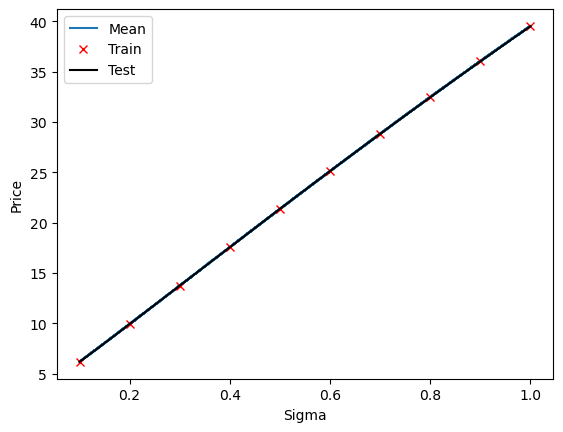

In [982]:
# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=0)


# plot 
Xr = X.ravel()
mu_sr = mu_s.ravel()

plt.plot(X, mu_sr, label='Mean')

plt.plot(X_train, Y_train, 'rx', label ='Train')
Y_test=np.array([call_BS(So, K,T,r,s) for s in X],dtype='float32')
plt.plot(X,Y_test,'k',label ='Test')
plt.ylabel("Price")
plt.xlabel("Sigma")
plt.legend()

In [983]:
RMSE = np.sqrt(np.mean((Y_test-mu_s)**2))
print(RMSE)

0.02616850538421748


<a id='sec1'></a>
## I-Volatilité implicite  définition et explication




Comment trouver $\sigma$ tel que  

$$ P - BS\;(S, K, T, r, \sigma)  = 0 $$

Pour $S, K, T, r$ fixé ?


La volatilité implicite a est la valeur de la volatilité qui, lorsqu'elle est insérée dans l'équation de Black-Scholes ou autre modèle, donne le prix de marché actuel de l'option. Comme il n'y a pas de formule analytique pour a en fonction des autres variables, elle est trouvée en utilisant des méthodes de résolutions numériques tel que $\textit{Brent}$ ou $\textit{fsolver}$.

En résumé, pour trouver la volatilité implicite, On doit résoudre l'équation ci-dessus pour en utilisant le prix de marché de l'option Call P.


## Expérimentation

<a id='sec1.1'></a>
### Partie 1 : Apprendre GPR sur la volatilité implicite avec le modèle de Black-scholes

La formule de Lewis pour le prix d'une option d'achat (call) est généralement exprimée comme suit :
$$C(S,K,T) = S_0 - \frac{e^{-rT}}{\pi} \int_{-\infty}^{\infty} \frac{\text{Re}[e^{ix\log(S/K)}\phi(x - i)]}{x} dx$$
où :

$C(S, K, T) \quad \text{est le prix de l'option d'achat,}$ \\
$S_0 \quad \text{est le prix actuel de l'actif sous-jacent,}$ \\
$K \quad \text{est le prix d'exercice de l'option,}$ \
$T \quad \text{est le temps restant jusqu'à l'expiration de l'option,} $\
$r \quad \text{est le taux d'intérêt sans risque,} $\
$\phi(u) \quad \text{est la fonction caractéristique de la distribution logarithmique de l'actif sous-jacent.}$

<a id='sec1.1.1'></a>
#### A- Première approche : A partir des prix de l'option P trouver la volatilité implicite et l'apprendre avec GPR

In [984]:
import scipy.stats as ss


class Option_param():
    """
    Option class wants the option parameters:
    S0 = current stock price
    K = Strike price
    T = time to maturity
    v0 = (optional) spot variance 
    exercise = European or American
    """
    def __init__(self, S0=15, K=15, T=1, v0=0.04, payoff="call", exercise="European"):
        self.S0 = S0
        self.v0 = v0
        self.K = K
        self.T = T
        
        if (exercise=="European" or exercise=="American"):
            self.exercise = exercise
        else: 
            raise ValueError("invalid type. Set 'European' or 'American'")
        
        if (payoff=="call" or payoff=="put"):
            self.payoff = payoff
        else: 
            raise ValueError("invalid type. Set 'call' or 'put'")


            
class Diffusion_process():
    """
    Class for the diffusion process:
    r = risk free constant rate
    sig = constant diffusion coefficient
    mu = constant drift 
    """
    def __init__(self, r=0.1, sig=0.2, mu=0.1):
        self.r = r
        self.mu = mu
        if (sig<=0):
            raise ValueError("sig must be positive")
        else:
            self.sig = sig

    def exp_RV(self, S0, T, N):
        W = ss.norm.rvs( (self.r-0.5*self.sig**2)*T , np.sqrt(T)*self.sig, N )
        S_T = S0 * np.exp(W)
        return S_T.reshape((N,1))
    
    
    

class BS_pricer():
    """
    Closed Formula.
    
    """
    def __init__(self, Option_info, Process_info ):
        """
        Process_info:  of type Diffusion_process. It contains (r,mu, sig) i.e.  interest rate, drift coefficient, diffusion coefficient
    
        Option_info:  of type Option_param. It contains (S0,K,T) i.e. current price, strike, maturity in years
        """
        self.r = Process_info.r           # interest rate
        self.sig = Process_info.sig       # diffusion coefficient
        self.S0 = Option_info.S0          # current price
        self.K = Option_info.K            # strike
        self.T = Option_info.T            # maturity in years
        self.exp_RV = Process_info.exp_RV # function to generate solution of GBM
        
        self.price = 0
        self.S_vec = None
        self.price_vec = None
        self.mesh = None
        self.exercise = Option_info.exercise
        self.payoff = Option_info.payoff
        
        
    def payoff_f(self, S):
        if self.payoff == "call":
            Payoff = np.maximum( S - self.K, 0 )
        elif self.payoff == "put":    
            Payoff = np.maximum( self.K - S, 0 )  
        return Payoff
        
    
    @staticmethod
    def BlackScholes(payoff='call', S0=100., K=100., T=1., r=0.1, sigma=0.2 ):
        """ Black Scholes closed formula:
            payoff: call or put.
            S0: float.    initial stock/index level.
            K: float strike price.
            T: float maturity (in year fractions).  
            r: float constant risk-free short rate.
            sigma: volatility factor in diffusion term. """
   
        d1 = (np.log(S0/K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S0/K) + (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T))

        if payoff=="call":
            return S0 * ss.norm.cdf( d1 ) - K * np.exp(-r * T) * ss.norm.cdf( d2 )
        elif payoff=="put":
            return K * np.exp(-r * T) * ss.norm.cdf( -d2 ) - S0 * ss.norm.cdf( -d1 )
        else:
            raise ValueError("invalid type. Set 'call' or 'put'")
    
    
    @staticmethod        
    def vega(sigma, S0, K, T, r):
        """ BS vega: derivative of the price with respect to the volatility """
        d1 = (np.log(S0/K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        return S0 * np.sqrt(T) * ss.norm.pdf(d1)
    
    
    def closed_formula(self):
        """ 
        Black Scholes closed formula:
        """
        d1 = (np.log(self.S0/self.K) + (self.r + self.sig**2 / 2) * self.T) / (self.sig * np.sqrt(self.T))
        d2 = (np.log(self.S0/self.K) + (self.r - self.sig**2 / 2) * self.T) / (self.sig * np.sqrt(self.T))

        if self.payoff=="call":
            return self.S0 * ss.norm.cdf( d1 ) - self.K * np.exp(-self.r * self.T) * ss.norm.cdf( d2 )
        elif self.payoff=="put":
            return self.K * np.exp(-self.r * self.T) * ss.norm.cdf( -d2 ) - self.S0 * ss.norm.cdf( -d1 )
        else:
            raise ValueError("invalid type. Set 'call' or 'put'")
    
    
        
    def FFT(self, K):
        """
        FFT method. It returns a vector of prices.
        K is an array of strikes
        """
        K = np.array(K)
        cf_GBM = partial(cf_normal, mu=( self.r - 0.5 * self.sig**2 )*self.T, sig=self.sig*np.sqrt(self.T))  # function binding
        if self.payoff == "call":
            return fft_Lewis(K, self.S0, self.r, self.T, cf_GBM, interp="cubic")
        elif self.payoff == "put":    # put-call parity
            return fft_Lewis(K, self.S0, self.r, self.T, cf_GBM, interp="cubic") - self.S0 + K*np.exp(-self.r*self.T)
        else:
            raise ValueError("invalid type. Set 'call' or 'put'")
              
    
            
def cf_normal(u, mu=1, sig=2):
    """
    Characteristic function of a Normal random variable
    """
    return np.exp( 1j * u * mu - 0.5 * u**2 * sig**2 )


def fft_Lewis(K, S0, r, T, cf, interp="cubic"):
    """ 
    K = vector of strike
    S = spot price scalar
    cf = characteristic function
    interp can be cubic or linear
    """
    N=2**15                          # FFT more efficient for N power of 2
    B = 500                          # integration limit 
    dx = B/N
    x = np.arange(N) * dx            # the final value B is excluded

    weight = np.arange(N)            # Simpson weights
    weight = 3 + (-1)**(weight+1)
    weight[0] = 1; weight[N-1]=1

    dk = 2*np.pi/B
    b = N * dk /2
    ks = -b + dk * np.arange(N)

    integrand = np.exp(- 1j * b * np.arange(N)*dx) * cf(x - 0.5j) * 1/(x**2 + 0.25) * weight * dx/3
    integral_value = np.real( ifft(integrand)*N )
    
    if interp == "linear":
        spline_lin = interp1d(ks, integral_value, kind='linear')
        prices = S0 - np.sqrt(S0 * K) * np.exp(-r*T)/np.pi * spline_lin( np.log(S0/K) )
    elif interp == "cubic":
        spline_cub = interp1d(ks, integral_value, kind='cubic')
        prices = S0 - np.sqrt(S0 * K) * np.exp(-r*T)/np.pi * spline_cub( np.log(S0/K) )
    return prices


def cf_Heston_good(u, t, v0, mu, kappa, theta, sigma, rho):
    """
    Heston characteristic function as proposed by Schoutens (2004)
    """
    xi = kappa - sigma*rho*u*1j
    d = np.sqrt( xi**2 + sigma**2 * (u**2 + 1j*u) )
    g1 = (xi+d)/(xi-d)
    g2 = 1/g1
    cf = np.exp( 1j*u*mu*t + (kappa*theta)/(sigma**2) * ( (xi-d)*t - 2*np.log( (1-g2*np.exp(-d*t))/(1-g2) ))\
              + (v0/sigma**2)*(xi-d) * (1-np.exp(-d*t))/(1-g2*np.exp(-d*t)) )
    return cf


def Q1(k, cf, right_lim):
    """
    P(X<k) - Probability to be in the money under the stock numeraire.
    cf: characteristic function
    right_lim: right limit of integration
    """
    integrand = lambda u: np.real( (np.exp(-u*k*1j) / (u*1j)) * 
                                  cf(u-1j) / cf(-1.0000000000001j) )  
    return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=2000 )[0]


def Q2(k, cf, right_lim):
    """
    P(X<k) - Probability to be in the money under the money market numeraire
    cf: characteristic function
    right_lim: right limit of integration
    """
    integrand = lambda u: np.real( np.exp(-u*k*1j) /(u*1j) * cf(u) )
    return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=2000 )[0]
     

In [985]:
import scipy.optimize as scpo

def implied_volatility( price, S0, K, T, r, method="fsolve" ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return ( price - BS.BlackScholes(S0=S0, K=K, T=T, r=r, sigma=vol) )
    
    if method == "brent":
        x, r = scpo.brentq( obj_fun, a=1e-15, b=500, full_output=True)
        if r.converged == True:
            return x
    if method == "fsolve":
        X0 = [0.1, 0.5, 1, 3]   # set of initial guess points
        for x0 in X0:
            x, _, solved, _ = scpo.fsolve( obj_fun, x0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]  

    return -1

In [986]:
T=1
S0=100
K=100
sig=0.3
r=0.1

opt_param = Option_param(S0=S0, K=K, T=T, v0=0.04, exercise="European", payoff="call" )
diff_param = Diffusion_process(r, sig)

BS=BS_pricer(opt_param, diff_param)

In [987]:
strikes = np.arange(50,301,5)
BS_prices = BS.FFT(K=strikes)
print(strikes)

[ 50  55  60  65  70  75  80  85  90  95 100 105 110 115 120 125 130 135
 140 145 150 155 160 165 170 175 180 185 190 195 200 205 210 215 220 225
 230 235 240 245 250 255 260 265 270 275 280 285 290 295 300]


In [988]:
IV_BS = []
for i in range(len(strikes)):
    IV_BS.append(implied_volatility( BS_prices[i], S0 = 100, K=strikes[i], T=1, r=0.1 ) )
    
IV_BS[0:20] 


[0.2999999962254875,
 0.29999998983043663,
 0.2999999936804837,
 0.2999999966528276,
 0.29999999711682496,
 0.2999999997941499,
 0.2999999998309792,
 0.3000000000595586,
 0.3000000010722753,
 0.30000000013524525,
 0.2999999999999997,
 0.3000000003825751,
 0.30000000222875706,
 0.300000000416362,
 0.3000000021819694,
 0.3000000010950224,
 0.3000000003365514,
 0.3000000002634524,
 0.3000000004791535,
 0.3000000004019753]

**Conculsion** : On obtient bien des valeurs proches de la volatilité mise au départ (0.3), car la Fonction de BS est injective pour $\sigma$

In [1001]:
train = np.random.rand(10).reshape(10,1) #random value

#Lower bound and Upper bound k 
lb_k=50
ub_k=200
strikes_train=[lb_k+(ub_k-lb_k)*k for k in train]

X_train = np.array([BS.FFT(lb_k+(ub_k-lb_k)*k) for k in train ],dtype='float32').reshape(-1,1)
Y_train = np.array([implied_volatility( X_train[i], S0 = 100, K=strikes_train[i], T=1, r=0.1 ) for i in range(len(strikes_train))],dtype='float32')


test = np.random.rand(1000).reshape(1000,1)
strikes_test=[lb_k+(ub_k-lb_k)*k for k in test]

X =  np.array([BS.FFT(lb_k+(ub_k-lb_k)*k) for k in test ],dtype='float32').reshape(-1,1)
Y_test = np.array([implied_volatility( X[i], S0 = 100, K=strikes_test[i], T=1, r=0.1 ) for i in range(len(strikes_test))],dtype='float32')


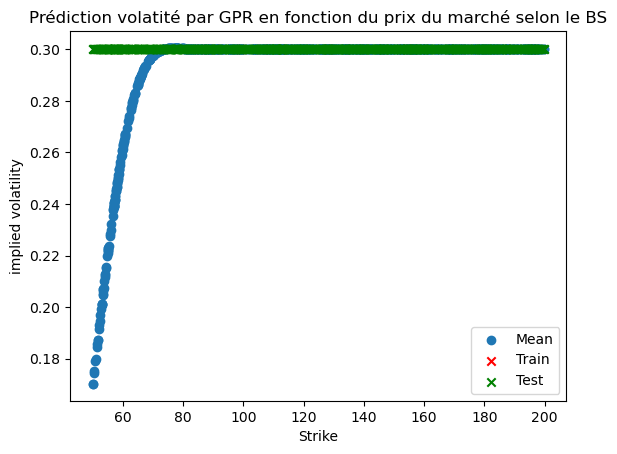

In [1002]:
# Compute mean and covariance of the posterior predictive distribution
mu_BS, cov_BS = posterior_predictive(X, X_train, Y_train, l=15, sigma_f=1.0, sigma_y=0)

# plot 
#Xr = X.ravel()
Xr = np.array(strikes_test)
mu_sr = mu_BS.ravel()
    
plt.scatter(Xr, mu_sr, label='Mean')

plt.scatter(np.array(strikes_train), Y_train,  color='r', marker='x', label ='Train')
plt.scatter(np.array(strikes_test),Y_test,  color='g', marker='x',label ='Test')
plt.ylabel("implied volatility")
plt.xlabel("Strike")
plt.title("Prédiction volatité par GPR en fonction du prix du marché selon le BS")
#plt.ylim(0, 0.8)
plt.legend()
plt.show()

In [1003]:
RMSE_BS = np.sqrt(np.mean((Y_test-mu_BS)**2))
print(RMSE_BS)

0.023364681210226956


<a id='sec1.1.2'></a>
#### B- Deuxième approche : Apprendre GPR sur les prix de l'option de BS et sur les prix prédit par GPR retrouvés la volatilité implicite

In [1004]:
T=1
S0=100
sigma=0.3
r=0.1

In [1005]:
train = np.linspace(0,1,10) #random value train 

#Lower bound and Upper bound k 
lb_k=50
ub_k=150
strikes_train=[lb_k+(ub_k-lb_k)*k for k in train]

X_train = np.array(strikes_train).reshape(-1,1)
Y_train = np.array([call_BS(S0, lb_k+(ub_k-lb_k)*k,T,r,sigma) for k in train],dtype='float32').reshape(-1,1)

test = np.linspace(0,1,10000)  #random value test
strikes_test=[lb_k+(ub_k-lb_k)*k for k in test]

X =  np.array(strikes_test).reshape(-1,1)
Y_test = np.array([call_BS(S0, lb_k+(ub_k-lb_k)*k,T,r,sigma) for k in test],dtype='float32').reshape(-1,1)

print(Y_train, X_train, X_train.shape, X.shape, Y_train.shape)

[[54.783558 ]
 [44.90513  ]
 [35.498283 ]
 [27.005095 ]
 [19.796574 ]
 [14.03589  ]
 [ 9.670646 ]
 [ 6.506742 ]
 [ 4.294814 ]
 [ 2.7921684]] [[ 50.        ]
 [ 61.11111111]
 [ 72.22222222]
 [ 83.33333333]
 [ 94.44444444]
 [105.55555556]
 [116.66666667]
 [127.77777778]
 [138.88888889]
 [150.        ]] (10, 1) (10000, 1) (10, 1)


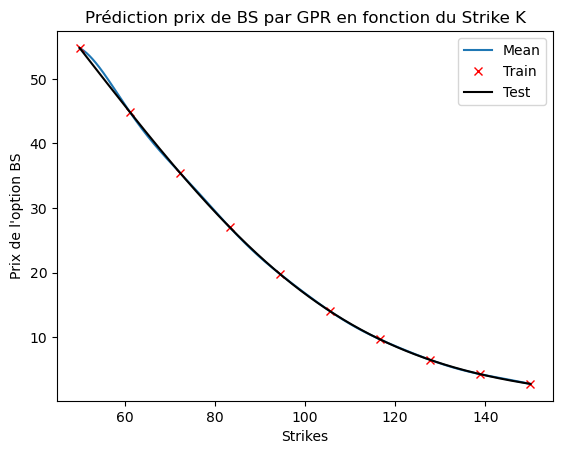

In [1006]:
# Compute mean and covariance of the posterior predictive distribution
mu_BS_price, cov_BS = posterior_predictive(X, X_train, Y_train, l=15, sigma_f=1.0, sigma_y=0)

# plot 
Xr = X.ravel()
mu_sr_price = mu_BS_price.ravel()
    
plt.plot(Xr, mu_sr_price, label='Mean')

plt.plot(X_train, Y_train,  'rx', label ='Train')
plt.plot(X,Y_test, 'k',label ='Test')
plt.ylabel("Prix de l'option BS")
plt.xlabel("Strikes")
plt.title("Prédiction prix de BS par GPR en fonction du Strike K")
#plt.ylim(0, 0.8)
plt.legend()
plt.show()


On voit bien que le GPR apprend bien les prix dans le modèle de Black&Scholes et fait de bonnes prédictions.

In [1007]:
IV_BS_gpr = []
for i in range(len(X)):
    IV_BS_gpr.append(implied_volatility( mu_BS_price[i], S0 = 100, K=strikes_test[i], T=1, r=0.1 ) )
    
#IV_BS_gpr   

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


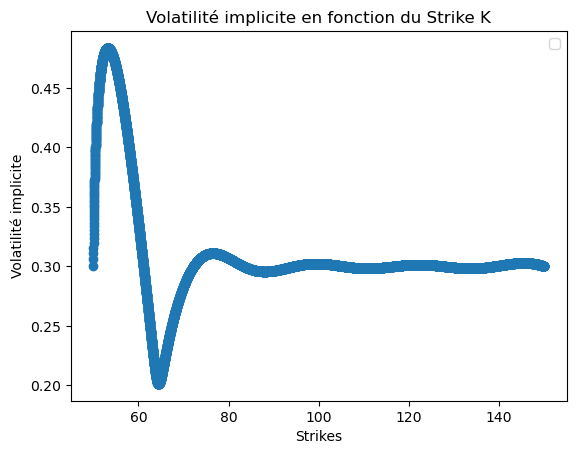

In [1008]:
plt.scatter(strikes_test,IV_BS_gpr)
plt.ylabel("Volatilité implicite")
plt.xlabel("Strikes")
plt.title("Volatilité implicite en fonction du Strike K")
#plt.ylim(0, 0.8)
plt.legend()
plt.show()

La courbe nous montre que que à partir d'un strike proche de 80, la volatilité implicite oscille autour de 0.3 sui est notre volatilité de départ. Donc on peut dire que GPR prédit bien la volatilité à partir des prix prédits par GPR;

**Conclulion** : Pour trouver la volatilité implicite présdite par GPR, on a procédé par deux méthodes et chacune des méthodes nous donnent un résulat assez satisfaisant et qui est en cohérence avec la volatilité de départ (0.3)

<a id='sec1.2'></a>
### Partie 2 : Apprendre GPR sur la volatilité implicite avec le modèle de Heston

Dans le modèle de Heston, la dynamique du prix de l'actif sous-jacent \( S(t) \) est décrite par l'équation stochastique suivante :

$\ dS(t) = rS(t)dt + \sqrt{v(t)}S(t)dW_1(t) \$

où :

$ r $ est le taux d'intérêt sans risque,

$v(t)$ est le processus stochastique de la volatilité instantanée,

$W_1(t)$ est un mouvement brownien standard sous la probabilité risque-neutre.


Le modèle de Heston introduit également une équation stochastique pour la volatilité \( v(t) \), donnée par :

$$\ dv(t) = \kappa(\theta - v(t))dt + \sigma \sqrt{v(t)}dW_2(t) \$$

où :

$kappa$ est le coefficient de vitesse de la volatilité,

$theta$ est la longue volatilité,

$sigma$ est la volatilité de la volatilité,

$W_1(t)$ et $W_2(t)$ sont des mouvements browniens standard sous la probabilité risque-neutre, et \( \rho \) est le coefficient de corrélation entre les deux mouvements browniens.

In [1009]:
from scipy.fftpack import ifft
from scipy.interpolate import interp1d

from scipy.optimize import fsolve

        
class Heston_pricer():
    """
    Class to price the options with the Heston model by: Fourier-inversion.
    """
 
    def cf_Heston_good(u, t, v0, mu, kappa, theta, sigma, rho):
        """
        Heston characteristic function as proposed by Schoutens (2004)
        """
        xi = kappa - sigma*rho*u*1j
        d = np.sqrt( xi**2 + sigma**2 * (u**2 + 1j*u) )
        g1 = (xi+d)/(xi-d)
        g2 = 1/g1
        cf = np.exp( 1j*u*mu*t + (kappa*theta)/(sigma**2) * ( (xi-d)*t - 2*np.log( (1-g2*np.exp(-d*t))/(1-g2) ))\
                  + (v0/sigma**2)*(xi-d) * (1-np.exp(-d*t))/(1-g2*np.exp(-d*t)) )
        return cf

   
    def Q1(k, cf, right_lim):
        """
        P(X<k) - Probability to be in the money under the stock numeraire.
        cf: characteristic function
        right_lim: right limit of integration
        """
        integrand = lambda u: np.real( (np.exp(-u*k*1j) / (u*1j)) * 
                                      cf(u-1j) / cf(-1.0000000000001j) )  
        return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=2000 )[0]


    def Q2(k, cf, right_lim):
        """
        P(X<k) - Probability to be in the money under the money market numeraire
        cf: characteristic function
        right_lim: right limit of integration
        """
        integrand = lambda u: np.real( np.exp(-u*k*1j) /(u*1j) * cf(u) )
        return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=2000 )[0]


    def Fourier_inversion(K, S0, T,v0, r, theta, rho, kappa, sigma):
        """
        Price obtained by inversion of the characteristic function
        """
        k = np.log(K/S0)                # log moneyness
        cf_H_b_good = partial(Heston_pricer.cf_Heston_good, t=T, v0=v0, mu=r, theta=theta, 
                                  sigma=sigma, kappa=kappa, rho=rho ) 
        
        limit_max = 2000      # right limit in the integration                
        
        call = S0 * Heston_pricer.Q1(k, cf_H_b_good, limit_max) \
                                                -K * np.exp(-r*T) * Heston_pricer.Q2(k, cf_H_b_good, limit_max)
        return call



In [1010]:
mu=0.1; rho=-0.3; sigma=0.6; theta=0.04; kappa=5
T = 1
S0 = 100
v0=0.04

In [1011]:
train = np.random.rand(10).reshape(10,1)
lb_k=50
ub_k=150
strikes_train=[lb_k+(ub_k-lb_k)*k for k in train]

X_train = np.array([Heston_pricer.Fourier_inversion(lb_k+(ub_k-lb_k)*k, S0, T,v0, r, theta, rho, kappa, sigma ) for k in train ],dtype='float32').reshape(-1,1)
Y_train = np.array([implied_volatility( X_train[i], S0 = 100, K=strikes_train[i], T=1, r=0.1 ) for i in range(len(strikes_train))],dtype='float32')

test = np.random.rand(1000).reshape(1000,1)
strikes_test=[lb_k+(ub_k-lb_k)*k for k in test]

X =  np.array([Heston_pricer.Fourier_inversion(lb_k+(ub_k-lb_k)*k, S0, T,v0, r, theta, rho, kappa, sigma ) for k in test ],dtype='float32').reshape(-1,1)
Y_test = np.array([implied_volatility( X[i], S0 = 100, K=strikes_test[i], T=1, r=0.1 ) for i in range(len(strikes_test))],dtype='float32')


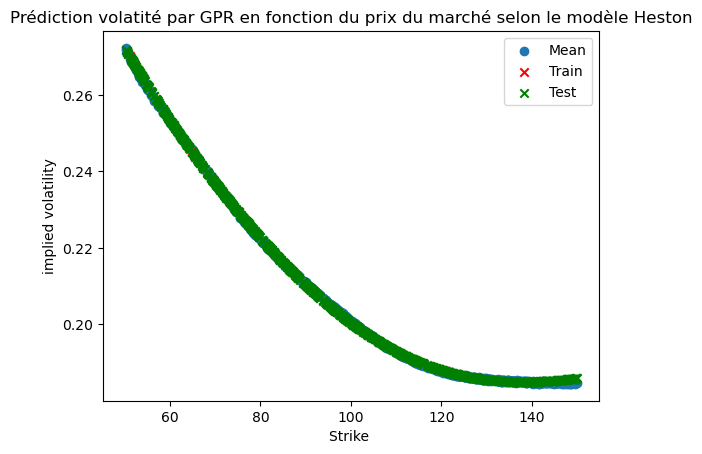

In [1012]:
# Compute mean and covariance of the posterior predictive distribution
#mu_hest, cov_hest = posterior_predictive(X, X_train, Y_train, l=31, sigma_f=15.0, sigma_y=0)
mu_hest, cov_hest = posterior_predictive(X, X_train, Y_train, l=31, sigma_f=15.0, sigma_y=0)

# plot 
#Xr = X.ravel()
Xr = strikes_test
mu_sr = mu_hest.ravel()

plt.scatter(Xr, mu_sr, label='Mean')

plt.scatter(strikes_train, Y_train,  color='r', marker='x', label ='Train')
plt.scatter(strikes_test,Y_test,  color='g', marker='x',label ='Test')
plt.ylabel("implied volatility")
plt.xlabel("Strike ")
plt.title("Prédiction volatité par GPR en fonction du prix du marché selon le modèle Heston")
plt.legend()

In [1013]:
RMSE_hest = np.sqrt(np.mean((Y_test-mu_hest)**2))
print(RMSE_hest)

0.0004172167108209185


On voit bien que notre GPR apprend bien la volatilité implicite dans le modèle de Black&Scholes. Et cela se confirme avec une RMSE très petite en prenant 1000 données pour le test.

<a id='sec1.3'></a>
### Partie 3 : Comparaison Heston et Black-Scholes

In [1017]:
strikes = np.arange(50,301,5)
Hest_prices = []

for k in strikes :
    
    Hest_prices.append(Heston_pricer.Fourier_inversion(k, S0, T,v0, r, theta, rho, kappa, sigma ))


In [1018]:
IV_Hest = []
for i in range(len(strikes)):
    IV_Hest.append(implied_volatility( Hest_prices[i], S0 = 100, K=strikes[i], T=1, r=0.05, method="fsolve" ) )
      

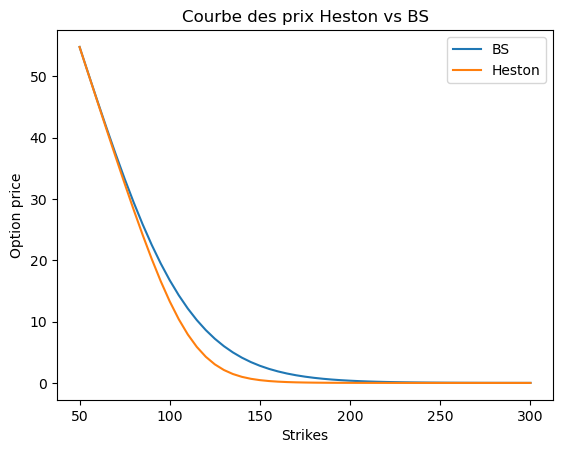

In [1019]:
plt.plot(strikes,BS_prices,label="BS")
plt.plot(strikes,Hest_prices,label="Heston")
plt.xlabel("Strikes")
plt.ylabel("Option price")
plt.title ("Courbe des prix Heston vs BS")
plt.legend()

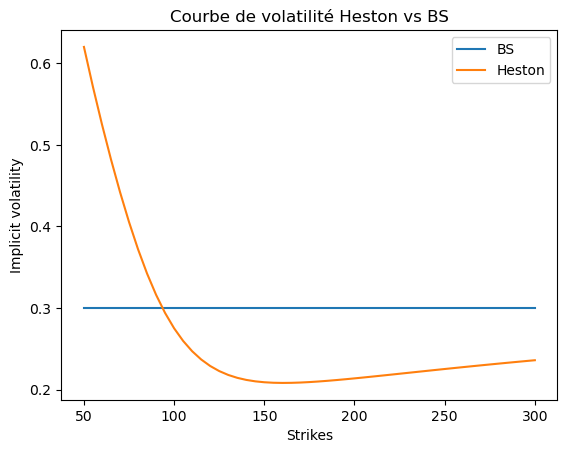

In [1020]:
plt.plot(strikes,IV_BS,label="BS")
plt.plot(strikes,IV_Hest,label="Heston")
plt.xlabel("Strikes")
plt.ylabel("Implicit volatility")
plt.title ("Courbe de volatilité Heston vs BS")
plt.legend()

On voit bien que la volatilité implicite pour Black&Scholes est constante et celle de Heston est variable avec une allure de $smile$.

In [1021]:
print("Différence de RMSE :", abs(RMSE_BS-RMSE_hest))

Différence de RMSE : 0.022947464499406038


<a id='sec2'></a>
### II : Surface de volatilité


Dans ce cas, on fait varier $K$ et $t$ dans l'équation $$ P - BS\;(S, K, T, r, \sigma) $$ pour trouver $\sigma$.

<a id='sec2.1'></a>
#### 1- Modèle de BS

In [1022]:
train = np.random.rand(20).reshape(10,2) #random value

#Lower bound and Upper bound k and T
lb_k=50
ub_k=150
lb_T=0.1
ub_T=1

strikes_train=np.array([lb_k+(ub_k-lb_k)*k for k in train[:,0]]).reshape(-1,1)
maturity_train=np.array([lb_T+(ub_T-lb_T)*T for T in train[:,1]]).reshape(-1,1)

vBS=np.vectorize(BS.BlackScholes)
X_train = np.array([vBS(payoff='call', S0=100., K=strikes_train, T=maturity_train, r=0.05, sigma=0.2 )]).reshape(-1,1)
# Y_train = np.array([implied_volatility( X_train[i], S0 = 100, K=strikes_train[i], T=1, r=0.1 ) for i in range(len(strikes_train))],dtype='float32')


test = np.random.rand(200).reshape(100,2)
strikes_test=np.array([lb_k+(ub_k-lb_k)*k for k in test[:,0]]).reshape(-1,1)
maturity_test=np.array([lb_T+(ub_T-lb_T)*T for T in test[:,1]]).reshape(-1,1)

X =  np.array([vBS(payoff='call', S0=100., K=strikes_test, T=maturity_test, r=0.05, sigma=0.2 )]).reshape(-1,1)


In [1023]:
vImplied_volatility = np.vectorize(implied_volatility)
Y_train =vImplied_volatility( X_train, S0 = 100, K=strikes_train, T= maturity_train, r=0.05 )
Y_train.shape, X_train.shape, strikes_train.shape, X.shape

((10, 1), (10, 1), (10, 1), (100, 1))

In [1024]:
Y_test =vImplied_volatility( X, S0 = 100, K=strikes_test, T= maturity_test, r=0.05 )
Y_train

array([[0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.1],
       [0.2],
       [0.1],
       [0.2],
       [0.2],
       [0.2]])

In [1025]:
#Y_test

In [1026]:
# Compute the prosterior predictive statistics with optimized kernel parameters and plot the results
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=10, sigma_f=1, sigma_y=1e-9)
#plot
mu_sr = mu_s.ravel()

(1000, 1) (1000, 1) (1000, 1)


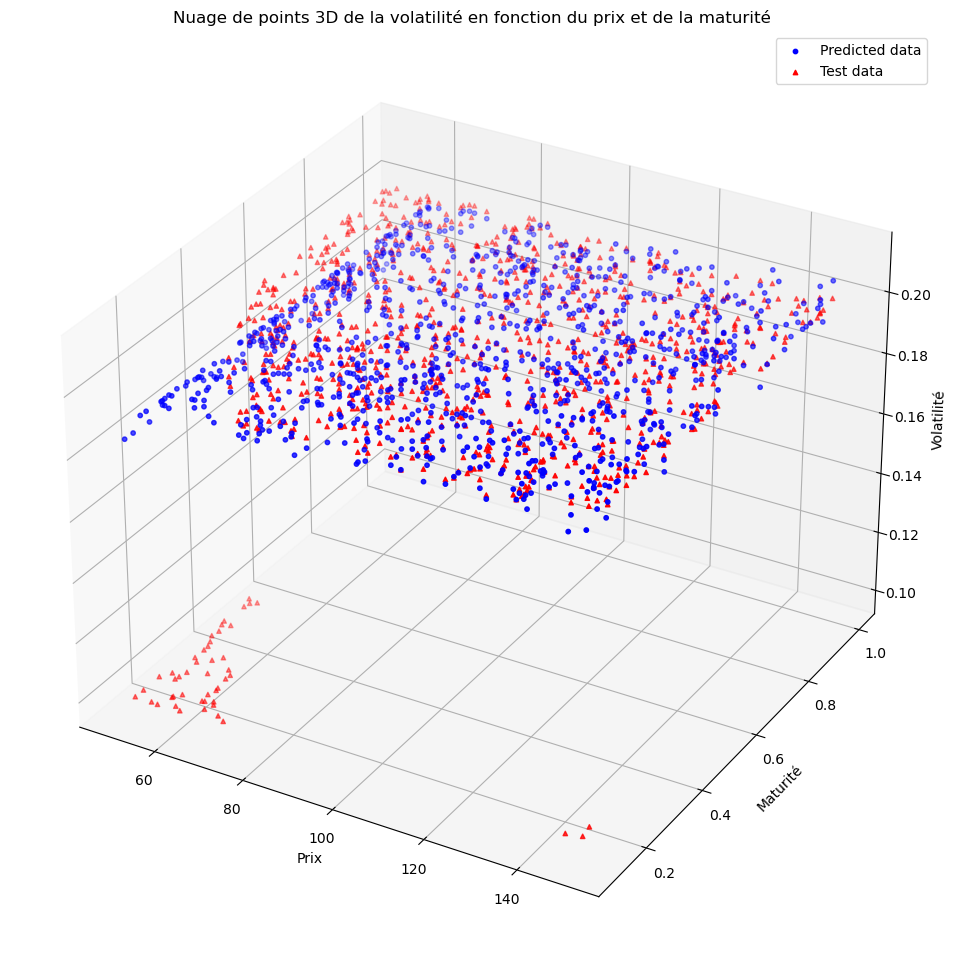

In [1033]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Générer des données de prix et de maturité (par exemple)
lb_k = 50
ub_k = 150
lb_T = 0.1
ub_T = 1

# Générer des données de prix et de maturité pour l'entraînement
train = np.random.rand(20).reshape(10, 2)
strikes_train = np.array([lb_k + (ub_k - lb_k) * k for k in train[:, 0]]).reshape(-1, 1)
maturity_train = np.array([lb_T + (ub_T - lb_T) * T for T in train[:, 1]]).reshape(-1, 1)
X_train = np.array([vBS(payoff='call', S0=100., K=strikes_train, T=maturity_train, r=0.05, sigma=0.2 )]).reshape(-1,1)
# Calculer les volatilités implicites pour les données d'entraînement
Y_train = vImplied_volatility(X_train, S0=100, K=strikes_train, T=maturity_train, r=0.05)

# Générer des données de prix et de maturité pour les tests
test = np.random.rand(2000).reshape(1000, 2)
strikes_test = np.array([lb_k + (ub_k - lb_k) * k for k in test[:, 0]]).reshape(-1, 1)
maturity_test = np.array([lb_T + (ub_T - lb_T) * T for T in test[:, 1]]).reshape(-1, 1)
X_test = np.array([vBS(payoff='call', S0=100., K=strikes_test, T=maturity_test, r=0.05, sigma=0.2 )]).reshape(-1,1)

print(X_test.shape, strikes_test.shape, maturity_test.shape)

# Calculer les volatilités implicites pour les données de test
Y_test = vImplied_volatility(X_test, S0=100, K=strikes_test, T=maturity_test, r=0.05 )
mu_s, cov_s = posterior_predictive(X_test, X_train, Y_train, l=15, sigma_f=1, sigma_y=1e-9)
# Tracer le scatter plot 3D
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Flatten les données pour les utiliser dans scatter
strikes_train_flat = strikes_train.flatten()
maturity_train_flat = maturity_train.flatten()
Y_train_flat = Y_train.flatten()

strikes_test_flat = strikes_test.flatten()
maturity_test_flat = maturity_test.flatten()
Y_test_flat = Y_test.flatten()

# Scatter plot des données d'entraînement
#ax.scatter(strikes_train_flat, maturity_train_flat, Y_train_flat, c='b', marker='o', label='Train data')
ax.scatter(strikes_test_flat, maturity_test_flat, mu_s, c='b', marker='o', s=10, label='Predicted data')

# Scatter plot des données de test
ax.scatter(strikes_test_flat, maturity_test_flat, Y_test_flat, c='r', marker='^', s=10, label='Test data')

# Ajouter des étiquettes et un titre
ax.set_xlabel('Prix')
ax.set_ylabel('Maturité')
ax.set_zlabel('Volatilité')
ax.set_title('Nuage de points 3D de la volatilité en fonction du prix et de la maturité')
ax.legend()

plt.show()


On constate tès bien que notre surface de volatilité est une constante autour de 0.2 qui est celle que nous avons prise pour simuler les prix de Black&Scholes. Ce qui est normal car notre fonction étant injective, elle devrait retourner les résultat pris au départ.

<a id='sec2.2'></a>
#### 2- Modèle Heston

In [1034]:
strikes_train =  np.arange(50,150,10) # K
maturities_train = np.arange(0.1, 1.01, 0.1) # en années
var_train = np.vstack((strikes_train,maturities_train)).T

vHestformula=np.vectorize(Heston_pricer.Fourier_inversion)
X_train = vHestformula( var_train[:,0], S0,var_train[:,1],v0, r,theta, rho, kappa, sigma).reshape(-1,1)
print(strikes_train.shape, maturities_train.shape)

(10,) (10,)


In [1035]:
vImplied_volatility = np.vectorize(implied_volatility)
Y_train =vImplied_volatility( X_train, S0 = 100, K=strikes_train, T= maturities_train, r=0.05 )
Y_train.shape

(10, 10)

In [1036]:
strikes_test=  np.arange(50,150,2) # K
maturities_test = np.arange(0.1, 1.01, (1.01 - 0.1) / 50) # en années
 #var_test = np.vstack((strikes_test,maturities_test)).T
print(strikes_test.shape, maturities_test.shape)
X_test =vHestformula( strikes_test,S0, maturities_test, v0,r, theta, rho, kappa, sigma).reshape(-1,1)

(50,) (50,)


In [1037]:
Y_test =vImplied_volatility( X_test, S0 = 100, K=strikes_test, T= maturities_test, r=0.05 )
Y_test.shape

(50, 50)

In [1038]:
# Compute the prosterior predictive statistics with optimized kernel parameters and plot the results
mu_s, cov_s = posterior_predictive(X_test, X_train, Y_train, l=1, sigma_f=1, sigma_y=1e-9)

mu_sr = mu_s.ravel()
print(mu_s.shape, X_test.shape, X_train.shape, Y_train.shape)

(50, 10) (50, 1) (10, 1) (10, 10)


(5000, 1) (5000, 1) (5000, 1)
(5000, 1) (5000, 1)


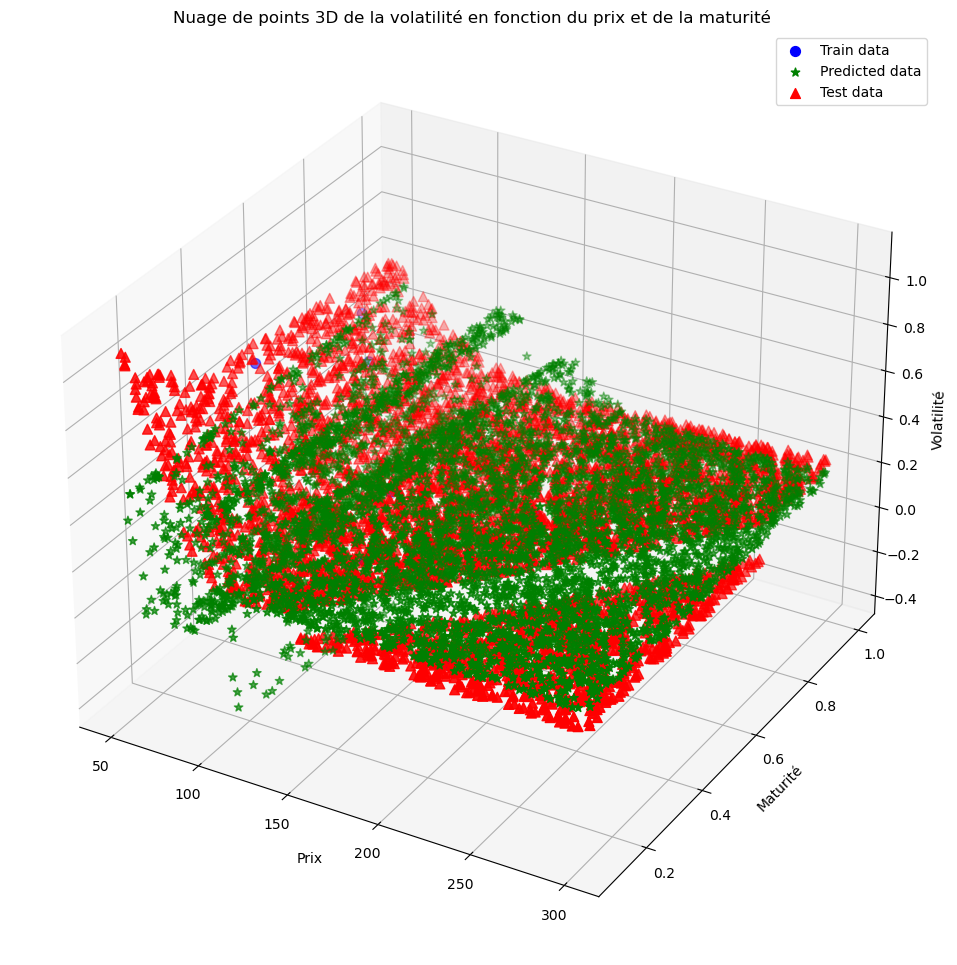

In [1039]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, axis =1).reshape(-1,1) + np.sum(X2**2, axis = 1) -2*np.dot(X1,X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=0):
    '''
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    
    # Equation (5)
    cov_s = K_ss-K_s.T.dot(K_inv).dot(K_s)
    
    
    return mu_s, cov_s


# Générer des données de prix et de maturité (par exemple)
lb_k = 50
ub_k = 300
lb_T = 0.1
ub_T = 1
mu=0.1; rho=-0.3; sigma=0.6; theta=0.04; kappa=5
T = 1
S0 = 100
v0=0.04
vHestformula=np.vectorize(Heston_pricer.Fourier_inversion)

#strikes = np.arange(50,301,5)

# Générer des données de prix et de maturité pour l'entraînement
train = np.random.rand(20).reshape(10, 2)
strikes_train = np.array([lb_k + (ub_k - lb_k) * k for k in train[:, 0]]).reshape(-1, 1)
maturity_train = np.array([lb_T + (ub_T - lb_T) * T for T in train[:, 1]]).reshape(-1, 1)
X_train = vHestformula(strikes_train, S0, maturity_train, v0, r, theta, rho, kappa, sigma).reshape(-1,1)
# Calculer les volatilités implicites pour les données d'entraînement
Y_train = vImplied_volatility(X_train, S0=100, K=strikes_train, T=maturity_train, r=0.05)

# Générer des données de prix et de maturité pour les tests
test = np.random.rand(5000).reshape(2500, 2)
strikes_test = np.array([lb_k + (ub_k - lb_k) * k for k in test[:, 0]]).reshape(-1, 1)
maturity_test = np.array([lb_T + (ub_T - lb_T) * T for T in test[:, 1]]).reshape(-1, 1)
X_test = vHestformula(strikes_test, S0, maturity_test, v0, r,theta, rho, kappa, sigma).reshape(-1,1)

print(X_test.shape, strikes_test.shape, maturity_test.shape)

# Calculer les volatilités implicites pour les données de test
Y_test = vImplied_volatility(X_test, S0=100, K=strikes_test, T=maturity_test, r=0.05)
mu_s, cov_s = posterior_predictive(X_test, X_train, Y_train, l=2, sigma_f=1, sigma_y=1e-3)
mu_s_thresholded = np.clip(mu_s, -0.5, 0.5)
print(Y_test.shape, mu_s.shape)
# Tracer le scatter plot 3D
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')
#ax = plt.axes(projection ='3d')

# Flatten les données pour les utiliser dans scatter
strikes_train_flat = strikes_train.flatten()
maturity_train_flat = maturity_train.flatten()
Y_train_flat = Y_train.flatten()

strikes_test_flat = strikes_test.flatten()
maturity_test_flat = maturity_test.flatten()
Y_test_flat = Y_test.flatten()

# Scatter plot des données d'entraînement
ax.scatter(strikes_train_flat, maturity_train_flat, Y_train_flat, c='b', s=50, marker='o', label='Train data')
ax.scatter(strikes_test_flat, maturity_test_flat, mu_s_thresholded, c='g', cmap='magma', s=40, marker='*', label='Predicted data')
# Scatter plot des données de test
ax.scatter(strikes_test_flat.reshape(-1, 1), maturity_test_flat.reshape(-1, 1), Y_test_flat.reshape(-1, 1), c='r', cmap='cool', s=50, marker='^', label='Test data')

# Ajouter des étiquettes et un titre
ax.set_xlabel('Prix')
ax.set_ylabel('Maturité')
ax.set_zlabel('Volatilité')
ax.set_title('Nuage de points 3D de la volatilité en fonction du prix et de la maturité')
ax.legend()

plt.show()

Les résultats nous montrent qu'on a bien une surface de voaltilité qui répond bien au résultat voulu.

(2500, 1) (2500, 1) (2500, 1)


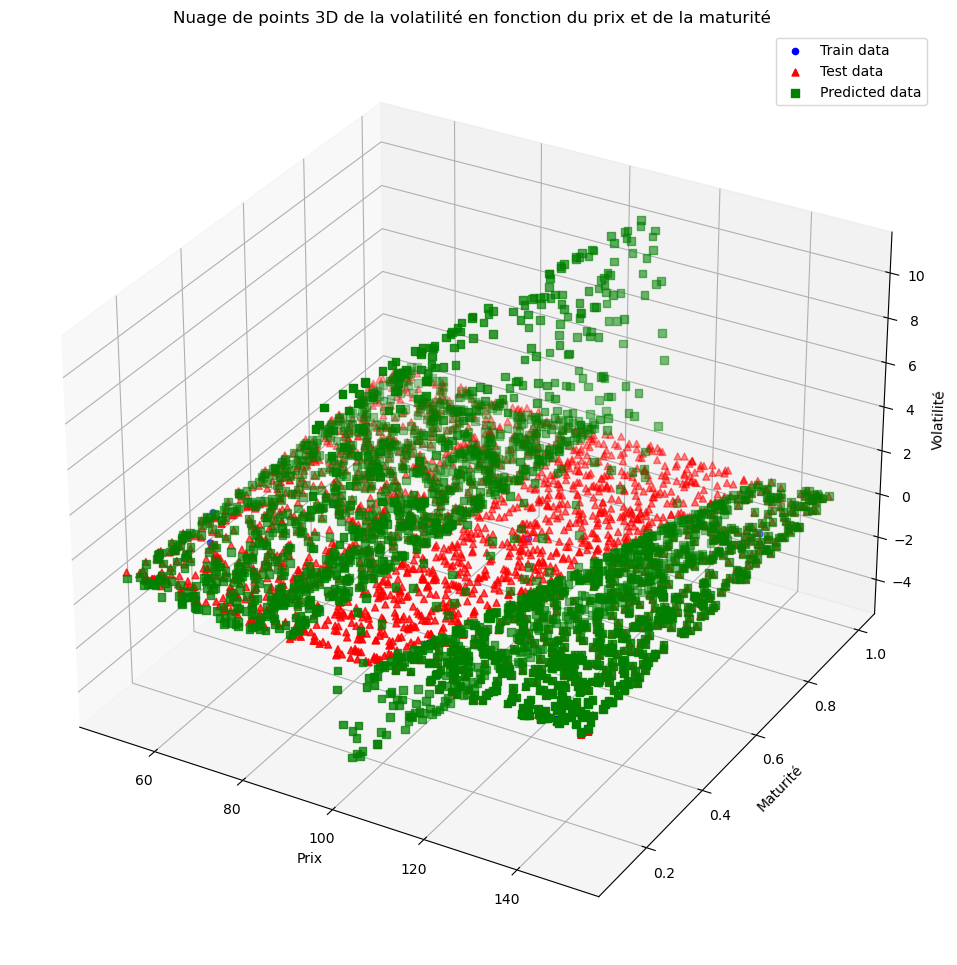

In [1040]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Générer des données de prix et de maturité (par exemple)
lb_k = 50
ub_k = 150
lb_T = 0.1
ub_T = 1

# Générer des données de prix et de maturité pour l'entraînement
train = np.random.rand(20).reshape(10, 2)
strikes_train = np.array([lb_k + (ub_k - lb_k) * k for k in train[:, 0]]).reshape(-1, 1)
maturity_train = np.array([lb_T + (ub_T - lb_T) * T for T in train[:, 1]]).reshape(-1, 1)

# Utiliser le modèle de Heston pour calculer les prix
X_train = X_train = vHestformula(strikes_train, S0, maturity_train, v0, r, theta, rho, kappa, sigma).reshape(-1,1)
# Calculer les volatilités implicites pour les données d'entraînement
Y_train = vImplied_volatility(X_train, S0=100, K=strikes_train, T=maturity_train, r=0.05)

# Générer des données de prix et de maturité pour les tests
test = np.random.rand(5000).reshape(2500, 2)
strikes_test = np.array([lb_k + (ub_k - lb_k) * k for k in test[:, 0]]).reshape(-1, 1)
maturity_test = np.array([lb_T + (ub_T - lb_T) * T for T in test[:, 1]]).reshape(-1, 1)

# Utiliser le modèle de Heston pour calculer les prix pour les données de test
X_test = vHestformula(strikes_test, S0, maturity_test, v0, r,theta, rho, kappa, sigma).reshape(-1,1)

# Calculer les volatilités implicites pour les données de test
Y_test = vImplied_volatility(X_test, S0=100, K=strikes_test, T=maturity_test, r=0.05)
print(Y_test.shape, strikes_test.shape, maturity_test.shape)
# Calculer la prédiction de la volatilité implicite pour les données de test
mu_s, cov_s = posterior_predictive(X_test, X_train, Y_train, l=3, sigma_f=1, sigma_y=1e-9)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Calculer la prédiction de la volatilité implicite pour les données de test
#mu_s = sigmoid(mu_s)
# Tracer le scatter plot 3D
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot des données d'entraînement
ax.scatter(strikes_train.flatten(), maturity_train.flatten(), Y_train.flatten(), c='b', marker='o', s=20, label='Train data')

# Scatter plot des données de test
ax.scatter(strikes_test.flatten(), maturity_test.flatten(), Y_test.flatten(), c='r', marker='^', s=25, label='Test data')

# Scatter plot des données prédites
ax.scatter(strikes_test.flatten(), maturity_test.flatten(), mu_s.flatten(), c='g', marker='s', s=30, label='Predicted data')

# Ajouter des étiquettes et un titre
ax.set_xlabel('Prix')
ax.set_ylabel('Maturité')
ax.set_zlabel('Volatilité')
ax.set_title('Nuage de points 3D de la volatilité en fonction du prix et de la maturité')
ax.legend()

plt.show()